<a href="https://colab.research.google.com/github/adity1234567/Deep-Dive-in-The-Field-of-Misinformation/blob/main/classify_FAKE_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/sasakitetsuya/how-can-we-classify-fake-news

Run the 3one first

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [1]:
!pip install gensim
!pip install numpy --upgrade --force-reinstall
!pip install gensim --upgrade --force-reinstall
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import gensim # This line will now work after gensim is installed.

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
!kaggle datasets download -d stevenpeutz/misinformation-fake-news-text-dataset-79k


Dataset URL: https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k
License(s): GNU Lesser General Public License 3.0
 90% 76.0M/84.6M [00:00<00:00, 103MB/s] 
100% 84.6M/84.6M [00:01<00:00, 78.6MB/s]


In [9]:
!ls


misinformation-fake-news-text-dataset-79k.zip  sample_data


In [11]:
!unzip /content/misinformation-fake-news-text-dataset-79k.zip -d /content/data/


Archive:  /content/misinformation-fake-news-text-dataset-79k.zip
  inflating: /content/data/DataSet_Misinfo_FAKE.csv  
  inflating: /content/data/DataSet_Misinfo_TRUE.csv  
  inflating: /content/data/EXTRA_RussianPropagandaSubset.csv  


In [60]:
df_true=pd.read_csv('/content/data/DataSet_Misinfo_FAKE.csv')
df_fake=pd.read_csv('/content/data/DataSet_Misinfo_TRUE.csv')


In [61]:
df_true

,Unnamed: 0,text
0,0,Donald Trump just couldn t wish all Americans ...
1,1,House Intelligence Committee Chairman Devin Nu...
2,2,"On Friday, it was revealed that former Milwauk..."
3,3,"On Christmas day, Donald Trump announced that ..."
4,4,Pope Francis used his annual Christmas Day mes...
...,...,...
43637,44422,The USA wants to divide Syria.\r\n\r\nGreat Br...
43638,44423,The Ukrainian coup d'etat cost the US nothing ...
43639,44424,The European Parliament falsifies history by d...
43640,44425,The European Parliament falsifies history by d...


Data cleaning

In [62]:
df_true['label']=1
df_true=df_true.drop(['Unnamed: 0'],axis=1)
df_true.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [63]:
df_fake['label']=0
df_fake=df_fake.drop(['Unnamed: 0'],axis=1)
df_fake.head()

,text,label
0,The head of a conservative Republican faction ...,0
1,Transgender people will be allowed for the fir...,0
2,The special counsel investigation of links bet...,0
3,Trump campaign adviser George Papadopoulos tol...,0
4,President Donald Trump called on the U.S. Post...,0


In [64]:
df=pd.concat([df_true,df_fake])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78617 entries, 0 to 34974
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78617 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [65]:
df=df.dropna(how="any") #This line of code removes all rows from the DataFrame df that contain any missing values (NaNs
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78588 entries, 0 to 34974
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78588 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


# Data preprocessing

just using stopword removal and regex

In [66]:
# Initialize target variable y from the 'label' column of the DataFrame
import nltk

# Download the 'punkt_tab' data package using nltk.download()
nltk.download('punkt_tab')  # Download the necessary data package for sentence tokenization

# Download 'stopwords' and 'punkt' data packages if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

y = df["label"].values

# Initialize an empty list to store tokenized words from the 'text' column
X = []

# Set of stop words in English
stop_words = set(nltk.corpus.stopwords.words("english"))

# Tokenizer to split sentences into words
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# Iterate over each paragraph in the 'text' column
for par in df["text"].values:
    tmp = []
    # Split the paragraph into sentences
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()  # Convert the sentence to lowercase
        tokens = tokenizer.tokenize(sent)  # Tokenize the sentence
        # Filter out stop words and words of length 1 or less
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)  # Add the filtered words to the list
    X.append(tmp)  # Add the tokenized words for this paragraph to X

# Delete the DataFrame from memory
del df

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Word2vec

In [67]:
EMBEDDING_DIM = 100

w2v_model = gensim.models.Word2Vec(
    sentences=X,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=1)

In [68]:
len(w2v_model.wv.index_to_key)

240843

In [25]:
w2v_model.wv["war"]

array([-0.60842246,  0.90223086,  1.4886839 , -2.2187126 , -4.5701237 ,
        0.43824965, -1.604171  , -0.80195075,  0.8680024 , -1.9712921 ,
        2.6624842 ,  0.905755  , -0.5051312 ,  1.0460665 ,  1.7466692 ,
        0.01939733, -0.5149737 ,  1.9422781 ,  0.85251653,  1.9898448 ,
        4.8272805 , -0.90566146,  0.36648452,  0.09401666, -3.4118674 ,
       -3.162037  ,  1.6848147 , -0.45208412, -2.5662577 , -0.5252829 ,
       -0.03054357, -0.7117366 ,  2.4401767 , -2.4961185 ,  2.1377475 ,
       -2.5200615 ,  2.6050966 ,  1.4609834 ,  1.7604018 ,  0.16460603,
       -1.4465834 ,  0.30423516, -2.343193  , -2.8336883 , -0.03497786,
       -1.392168  ,  3.1507297 , -0.37069646,  0.24550581, -0.11666191,
        0.19927788,  0.20777024,  4.630803  ,  0.02195106, -1.1121848 ,
        2.3376098 ,  0.20848998, -2.5266376 , -1.1731056 , -1.4362391 ,
       -0.5402459 ,  3.4189923 ,  4.3723373 , -2.2063553 ,  5.7007394 ,
        6.1131206 ,  3.1647515 ,  1.474386  , -2.8035946 , -3.31

In [26]:
w2v_model.wv.most_similar("pandemic")

[('viruses', 0.7071108818054199),
 ('dengue', 0.704767644405365),
 ('virus', 0.6869123578071594),
 ('infect', 0.6858103275299072),
 ('infectious', 0.6799716949462891),
 ('influenza', 0.6774933338165283),
 ('diphtheria', 0.6746421456336975),
 ('infection', 0.6616353988647461),
 ('epidemics', 0.6561434268951416),
 ('outbreaks', 0.6521515250205994)]

In [27]:
w2v_model.wv.most_similar("japan")

[('china', 0.7627449631690979),
 ('tokyo', 0.7106565833091736),
 ('philippines', 0.6803652048110962),
 ('india', 0.6792618632316589),
 ('japanese', 0.6719864010810852),
 ('beijing', 0.6652598977088928),
 ('asia', 0.6407628059387207),
 ('mainland', 0.6167382001876831),
 ('chinese', 0.6016034483909607),
 ('singapore', 0.5956474542617798)]

In [28]:
w2v_model.wv.most_similar("innovation")

[('innovative', 0.8239871263504028),
 ('technological', 0.7675613164901733),
 ('sustainable', 0.7206500768661499),
 ('entrepreneurship', 0.6933433413505554),
 ('technology', 0.6850790977478027),
 ('robotics', 0.6817084550857544),
 ('innovations', 0.6798048615455627),
 ('development', 0.6748149394989014),
 ('resource', 0.6728836894035339),
 ('ecosystem', 0.670549213886261)]

In [29]:
w2v_model.wv.most_similar(positive=["beatles","stones", "england"])

[('fountain', 0.7541189193725586),
 ('disco', 0.7284764647483826),
 ('guitar', 0.7153984308242798),
 ('reggae', 0.7112202644348145),
 ('strumming', 0.6842356324195862),
 ('hamlet', 0.6827384233474731),
 ('replica', 0.6750849485397339),
 ('cafe', 0.6729246973991394),
 ('ravine', 0.6724884510040283),
 ('beethoven', 0.6710785031318665)]

# Tokenization

In [70]:
new_X=X

In [72]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index)

# Print the vocabulary size
print("Vocabulary Size:", vocab_size)
X = tokenizer.texts_to_sequences(X)

Vocabulary Size: 240843


In [73]:
X[0][:10]

[23, 2, 2116, 107, 1412, 9, 20, 487, 336, 287]

In [74]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

said -> 1
trump -> 2
would -> 3
people -> 4
president -> 5
one -> 6
mr -> 7
clinton -> 8
new -> 9
also -> 10


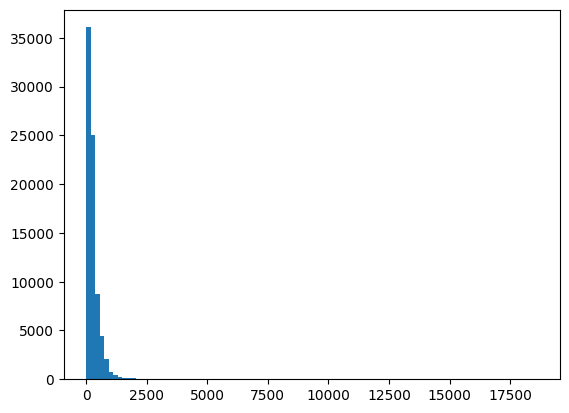

In [75]:
plt.hist([len(x) for x in X], bins=100)
plt.show()

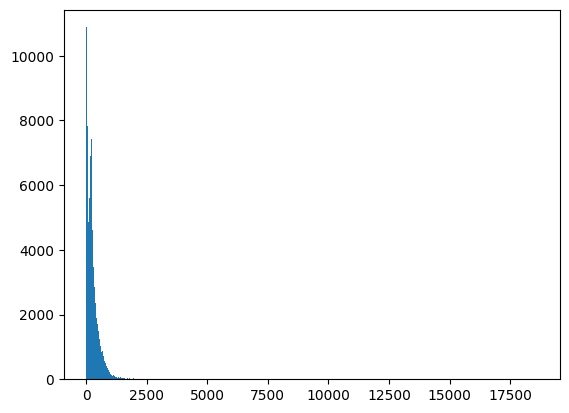

In [76]:
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [77]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 1000])

76721

76721 out of 78588 have less than 1000 words.

**pad_sequences ---> see : link dite hbe to know more about this**

ensure that all sequences in X (which should be a list of sequences, such as tokenized sentences) have the same length



In [78]:
maxlen = 1000

X = pad_sequences(X, maxlen=maxlen)

In [85]:

len(X[24084])

1000

In [82]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

240844

In [86]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

# Modeling

In [87]:
embedding_vectors = get_weight_matrix(w2v_model.wv, word_index)

This model takes a sentence, converts words into numbers (Embeddings), understands the order of words (LSTM), and makes a prediction (positive/negative) using sigmoid activation.

Deleting embedding_vectors frees up memory, preventing issues when training large models.
The model will still work because the embeddings are already inside the Embedding layer.

In [88]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [89]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      24,084,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,084,400 (91.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,084,400 (91.87 MB)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [91]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 1237s 957ms/step - acc: 0.8749 - loss: 0.2991 - val_acc: 0.9280 - val_loss: 0.1840
Epoch 2/6
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 1339s 1s/step - acc: 0.9385 - loss: 0.1624 - val_acc: 0.9545 - val_loss: 0.1231
Epoch 3/6
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 1335s 996ms/step - acc: 0.9588 - loss: 0.1085 - val_acc: 0.9600 - val_loss: 0.1064
Epoch 4/6
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 1336s 992ms/step - acc: 0.9727 - loss: 0.0750 - val_acc: 0.9662 - val_loss: 0.0938
Epoch 5/6
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 1282s 992ms/step - acc: 0.9798 - loss: 0.0583 - val_acc: 0.8770 - val_loss: 0.2590
Epoch 6/6
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 1285s 994ms/step - acc: 0.9638 - loss: 0.0945 - val_acc: 0.9607 - val_loss: 0.1219


In [92]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

614/614 ━━━━━━━━━━━━━━━━━━━━ 188s 305ms/step


In [93]:
accuracy_score(y_test, y_pred)

0.9591795185015524

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      8735
           1       0.94      0.99      0.96     10912

    accuracy                           0.96     19647
   macro avg       0.96      0.96      0.96     19647
weighted avg       0.96      0.96      0.96     19647

